# Camille Girard Think Bayes Homework 4

This notebook presents example code and exercise solutions for Think Bayes.

Camille Girard

MIT License: https://opensource.org/licenses/MIT

In [28]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import classes from thinkbayes2
from thinkbayes2 import Pmf, Suite, Beta, MakeGammaPmf, MakeJoint
import thinkbayes2

import matplotlib.pyplot as plt
import thinkplot
import pandas as pd
import numpy as np
from scipy.stats import norm, hypergeom
import math
from thinkbayes2 import MakePoissonPmf

class BayesTable(pd.DataFrame):
    def __init__(self, hypo, prior=1):
        columns = ['hypo', 'prior', 'likelihood', 'unnorm', 'posterior']
        super().__init__(columns=columns)
        self.hypo = hypo
        self.prior = prior
    
    def mult(self):
        self.unnorm = self.prior * self.likelihood
        
    def norm(self):
        nc = np.sum(self.unnorm)
        self.posterior = self.unnorm / nc
        return nc
    
    def update(self):
        self.mult()
        return self.norm()
    
    def reset(self):
        return BayesTable(self.hypo, self.posterior)

ERROR:root:The 'ast_node_interactivity' trait of a ZMQInteractiveShell instance must be any of ['all', 'last', 'last_expr', 'none'], but a value of 'last_expr_or_assign' <class 'str'> was specified.


# One More Height Problem

In a room of 10 randomly chosen U.S. residents, A is the second tallest.  How tall is A?  What is the probability that A is male?

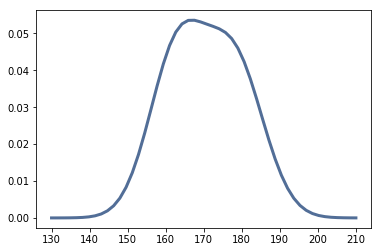

In [29]:
dist_height = dict(male=norm(178, 7.7), female=norm(163, 7.3))
heights = np.linspace(130, 210)
prob_m = dist_height['male'].pdf(heights)
prob_f = dist_height['female'].pdf(heights)
m_pmf = Pmf(dict(zip(heights, prob_m)))
f_pmf = Pmf(dict(zip(heights, prob_f)))
metapmf = Pmf([m_pmf,f_pmf])
mix = thinkbayes2.MakeMixture(metapmf)
thinkplot.Pdf(mix)

182.24489795918367

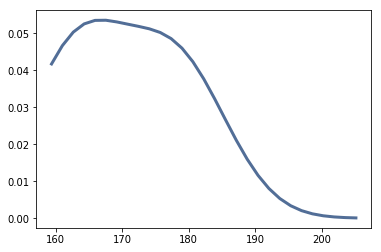

In [30]:
sampled = Pmf()
for i in range(1000000):
    group = mix.Sample(10)
    group.sort()
    h = group[8]
    prob = mix[h]
    sampled[h] = prob
    
thinkplot.Pdf(sampled)
average = np.mean(sampled)
average

In [31]:
A = mix
B = mix
def taller(person1, person2, difference):
    joint = MakeJoint(person1, person2)
    joint.Update(difference)
    return joint.Marginal(0), joint.Marginal(1)

In [32]:
for i in range(8):
    A, _ = taller(A, B, 'A')
    
A, B = taller(A, B, 'B');

AttributeError: 'Joint' object has no attribute 'Update'

# Lincoln Index Problem

Read How many errors are left to find?, and write a Bayesian solution to this problem:

Suppose two testers independently search for bugs. Let k1 be the number of errors the first tester finds and k2 the number of errors the second tester finds. Let c be the number of errors both testers find.  [I changed Cook's notation to be consistent with mine].

For concreteness, suppose the first tester finds 20 bugs, the second finds 15, and they find 3 in common.

Compare your solution to the Lincoln Index, which estimates the total number of errors as k1 k2 / c.

(110.0, 100)

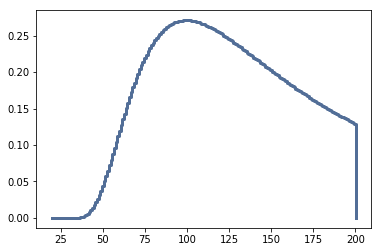

In [68]:
prb = hypergeom.pmf(3,range(20,201),20,15);
x = np.arange(20,201);

bugs = Pmf();

for i in range(0,181):
    pred = i + 20
    bugs[pred] = prb[i]

thinkplot.Pmf(bugs)
np.mean(bugs), bugs.MAP()

In [65]:
lincoln = (20*15)/3
lincoln

100.0

# The Skeet Problem

At the 2016 Summer Olympics in the Women's Skeet event, Kim Rhode faced Wei Meng in the bronze medal match. They each hit 15 of 25 skeets, sending the match into sudden death. In the first round, both hit 1 of 2 skeets. In the next two rounds, they each hit 2 skeets. Finally, in the fourth round, Rhode hit 2 and Wei hit 1, so Rhode won the bronze medal, making her the first Summer Olympian to win an individual medal at six consecutive summer games.

But after all that shooting, what is the probability that Rhode is actually a better shooter than Wei? If the same match were held again, what is the probability that Rhode would win?

As always, you will have to make some modeling decisions, but one approach is to estimate, for each shooter, the probability of hitting a skeet. Then, to estimate the probability that Rhode is a better shooter, you can draw samples from the two posterior distributions and compare them. To estimate the probability of winning a rematch, you could draw samples from the posterior distributions and simulate a round of 25 shots.

In [39]:
Rhode = Beta(1,1)
Rhode.Update((22,11))
Wei = Beta(1,1)
Wei.Update((21,12))

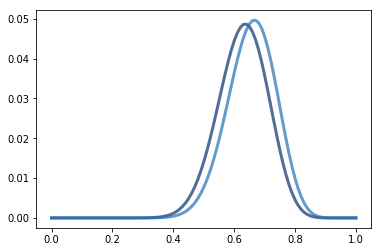

In [40]:
thinkplot.Pdf(Wei.MakePmf())
thinkplot.Pdf(Rhode.MakePmf())

In [41]:
# Is Rhodes Better?
r_sample = Rhode.MakeCdf(1000000).Sample(1000000)
w_sample = Wei.MakeCdf(1000000).Sample(1000000)
r_better = np.mean(r_sample > w_sample)
r_better

0.600242

Once the shots are taken into account with an even prior the probability of Rhodes being a better skeet shooter than Wei is between 59 and 60 percent - closer to 60

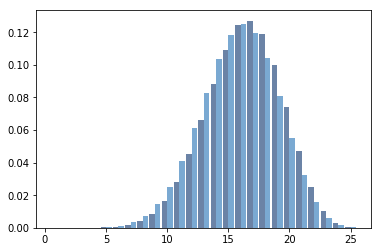

In [42]:
r_rematch = np.random.binomial(25, r_sample)
w_rematch = np.random.binomial(25,w_sample)
thinkplot.Hist(Pmf(r_rematch), width=0.45, align='right')
thinkplot.Hist(Pmf(w_rematch), width=0.45, align='left')

In [46]:
#Will Rhodes win a rematch?
r_win = np.mean(r_rematch > w_rematch)
r_tie = np.mean(r_rematch == w_rematch)
r_lose = np.mean(r_rematch < w_rematch)
r_win, r_tie, r_lose

(0.520052, 0.08879, 0.391158)

Rhodes has a 52 percent chance of winning a rematch against Wei and a 9 percent chance of a tie (meaning 39 percent chance of losing)

# The Social Desireability Problem

Whenever you survey people about sensitive issues, you have to deal with social desirability bias, which is the tendency of people to shade their answers in the direction they think shows them in the most positive light.

One of the ways to improve the quality of the results is to collect responses in indirect ways.  For example, here's a clever way one research group estimated the prevalence of atheists.

Another way is "randomized response", as described in this article or this video (if you can stand it).

As an example, suppose you ask 100 people to flip a coin and:

If they get heads, they report YES.
If they get tails, then honestly answer the question "Do you believe in God?"

And suppose you get 80 YESes and 20 NOs.

Estimate the prevalence of atheists in the surveyed population (by which, as always, I mean compute a posterior distribution).


# OTHER PROBLEM

# Project Ideas